In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.01
training_steps = 20000
batch_size = 256
display_step = 1000

# Network Parameters
num_hidden_1 = 128 # 1st layer num features.
num_hidden_2 = 64 # 2nd layer num features (the latent dim).
num_latent = 10

由于不需要预测数字，所以没有增加一维的数字位，可在后面修改

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Convert to float32.
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
# (60000, 784) 的x_train切片，切成60000份，每个train_data都是 784的大小
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# repeat() 相当于一个dataset训练两遍，batch是一次取出256个image的数据，prefetch(1)是每次预存一个batch，shuffle指一个pool有多大
train_data = train_data.repeat().shuffle(1000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

VAE的思路是，encoder得到均值和标准差（这里因为标准差总是正，所以最好训练log标准差，在采样的时候用exp来恢复），然后采样Z，然后用decoder将Z恢复成X，将X和原来的X对比。损失函数中，要尽量预测准确的同时，将Z的分布靠近标准正态。

In [5]:
def vae_loss(x_reconstructed, x_true, z_mean, z_std):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.math.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.math.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

In [6]:
class VAE(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder1 = tf.keras.layers.Dense(units=num_hidden_1, activation=tf.nn.tanh)
        self.encoder2 = tf.keras.layers.Dense(units=num_hidden_2, activation=tf.nn.sigmoid)
        self.z_mean = tf.keras.layers.Dense(units=num_latent)
        self.z_std = tf.keras.layers.Dense(units=num_latent)
        self.decoder1 = tf.keras.layers.Dense(units=num_hidden_1, activation=tf.nn.tanh)
        self.decoder2 = tf.keras.layers.Dense(units=num_features, activation=tf.nn.sigmoid)
        
    @tf.function
    def encode(self, inputs):
        x = self.encoder1(inputs)
        x = self.encoder2(x)
        return x
    
    @tf.function
    def decode(self, inputs):         
        x = self.decoder1(inputs)
        x = self.decoder2(x)
        return x
    
    def get_mean_and_std(self, inputs):
        mean = self.z_mean(inputs)
        std = self.z_std(inputs)
        return (mean, std)

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
vae = VAE()

# take 是取某个数量的batch的数据出来。enumerate只是为了增加一个index
for step, (x, _) in enumerate(train_data.take(training_steps + 1)):
    with tf.GradientTape() as g:
        latent = vae.encode(x)
        
        # 这里生成了batch_size * num_latent个参数，也就是每个输入X对应了多个参数
        (z_mean, z_std) = vae.get_mean_and_std(latent)
        
        # sample Z。Z服从各向同性的多元正态分布。Z的256个采样，是有服从同一个分布的，他们由一个多元标准正态的256个采样变换而来
        epsilon = tf.keras.backend.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0)
        z = z_mean + tf.exp(z_std / 2) * epsilon
        
        y_pred = vae.decode(z)
        loss = vae_loss(y_pred, x, z_mean, z_std)
        
        if step % display_step == 0:
            print("step: %i, loss: %f" % (step, loss))
        
    # Compute gradients.
    gradients = g.gradient(loss, vae.variables)

    optimizer.apply_gradients(grads_and_vars=zip(gradients, vae.variables))

step: 0, loss: 552.514832
step: 1000, loss: 135.477570
step: 2000, loss: 127.372505
step: 3000, loss: 133.500519
step: 4000, loss: 123.625198
step: 5000, loss: 124.480034
step: 6000, loss: 119.729446
step: 7000, loss: 124.872849
step: 8000, loss: 123.810883
step: 9000, loss: 122.742729
step: 10000, loss: 120.924126
step: 11000, loss: 118.826950
step: 12000, loss: 121.336548
step: 13000, loss: 117.173859
step: 14000, loss: 120.698990
step: 15000, loss: 119.321228
step: 16000, loss: 118.460464
step: 17000, loss: 118.397804
step: 18000, loss: 119.090248
step: 19000, loss: 117.661110
step: 20000, loss: 115.846603


In [29]:
def draw_all_in_a_batch(latent, n=16):
    num_new_img = n * n

    canvas_recon = np.empty((28 * n, 28 * n))
    new_images = vae.decode(latent)

    for i in range(n):
        for j in range(n):
#             # 这个id的大小要在batch_size之内，因为同时生成了这么多个，这里只是均匀地从中展示一部分
#             img = new_images[i*j].numpy().reshape([28, 28])
#             # 当i或者j有0时，这个i*j的结果总是0，所以可以看到0行0列的结果是一样的，因为都是第0张图
#             if i==0 or j == 0:
#                 img = new_images[i+j].numpy().reshape([28, 28])
                
            # 如果按照下面的方式，那么就不对称，而是按顺序全部写下来
            img = new_images[i*n+j].numpy().reshape([28, 28])
            
            # 两种方式都没有办法达到那种渐变效果，渐变效果是因为他的latent的生成受到了严格的控制，而不是像下面这样都是随机的
            
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
        
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

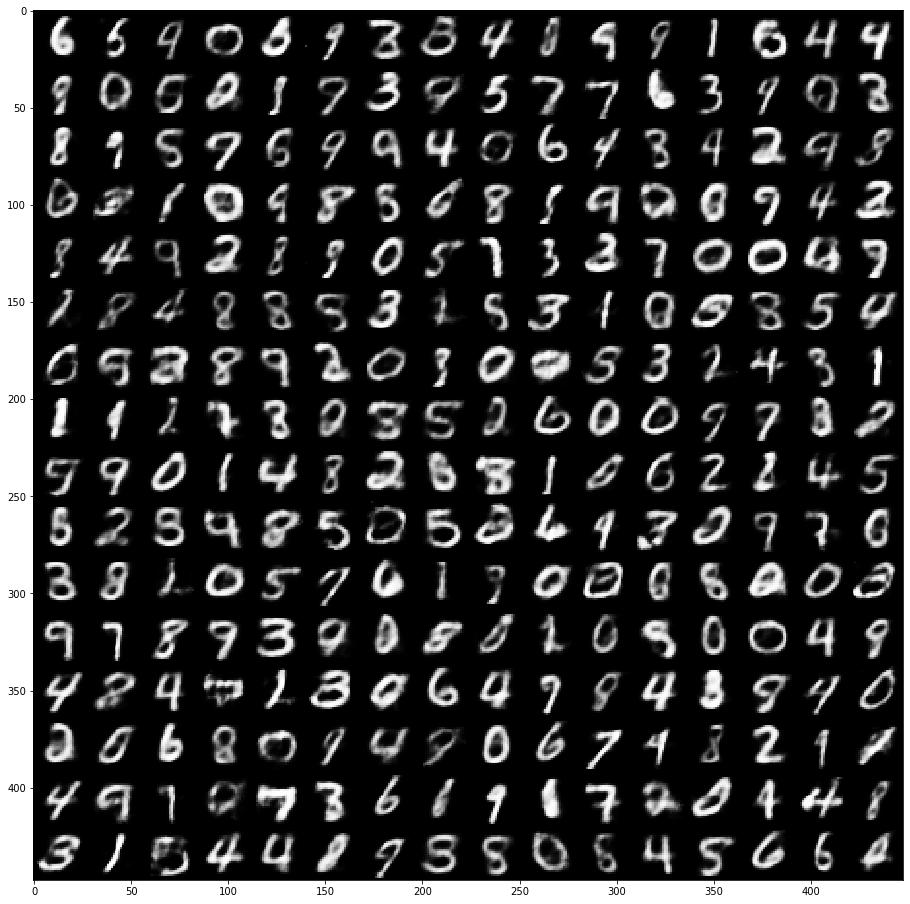

In [30]:
# 从标准正态分布中生成
draw_all_in_a_batch(tf.keras.backend.random_normal(shape=(256, num_latent), mean=0.0, stddev=1.0, dtype=None, seed=None))

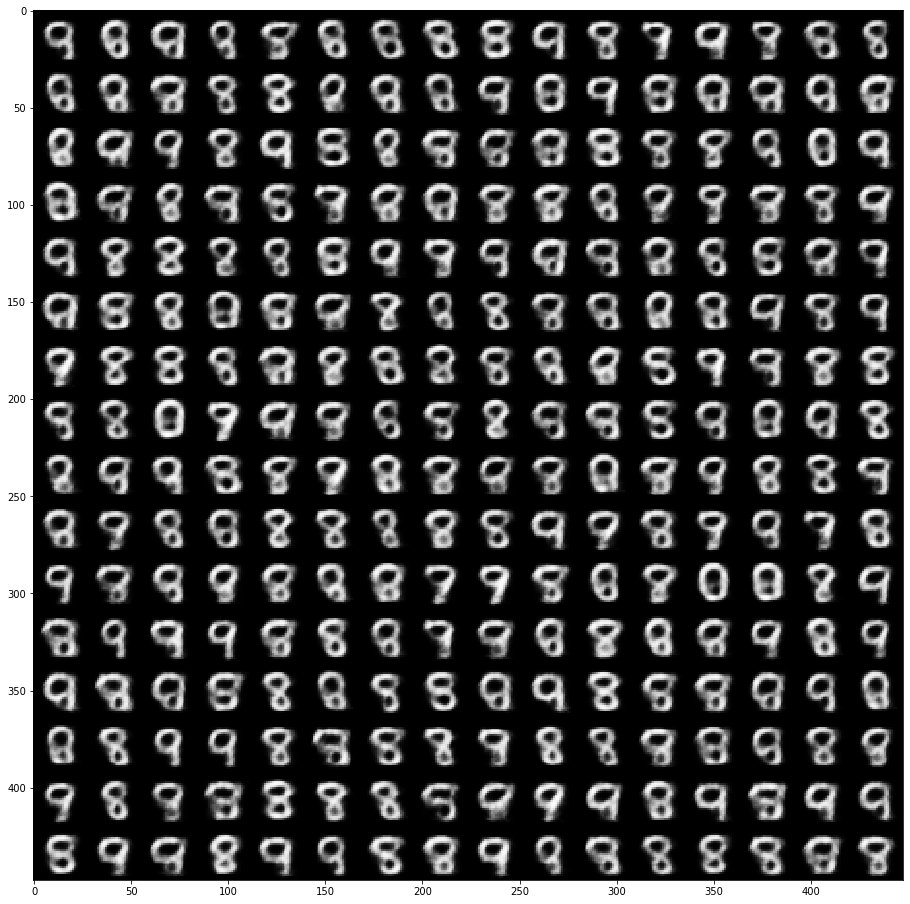

In [31]:
# 均匀分布
draw_all_in_a_batch(tf.keras.backend.random_uniform(shape=(256, num_latent), dtype=None, seed=None))

如果需要生成的有规律，那么在输入的时候就需要增加一定的规律，而不是用随机数输入

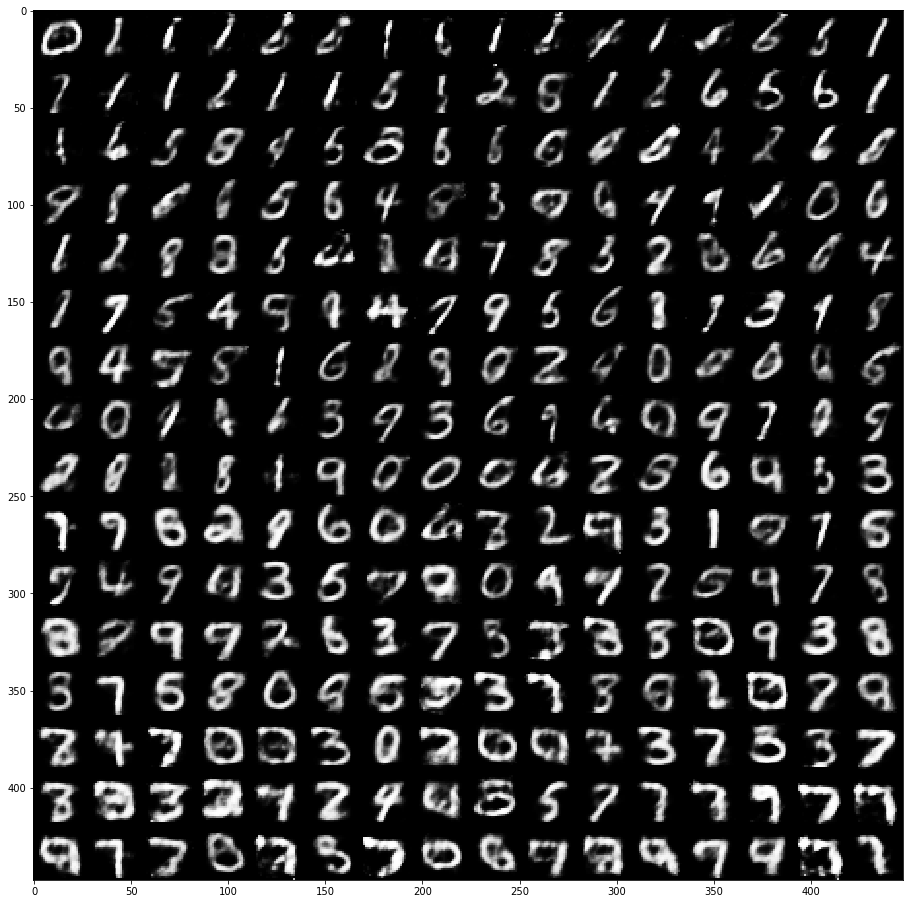

In [32]:
# 先生成255个从 -1 到 1 的递增序列，再按照这个序列作为均值，生成num_latent个latent，就生成了一个新的Z。
x_axis = np.linspace(-1, 1, 255)
ep = np.random.normal(0, 1, size=(1, num_latent))
for i in x_axis:
    ep = np.append(ep, np.random.normal(i, 1, size=(1, num_latent)), axis=0)
    
draw_all_in_a_batch(tf.convert_to_tensor(ep))

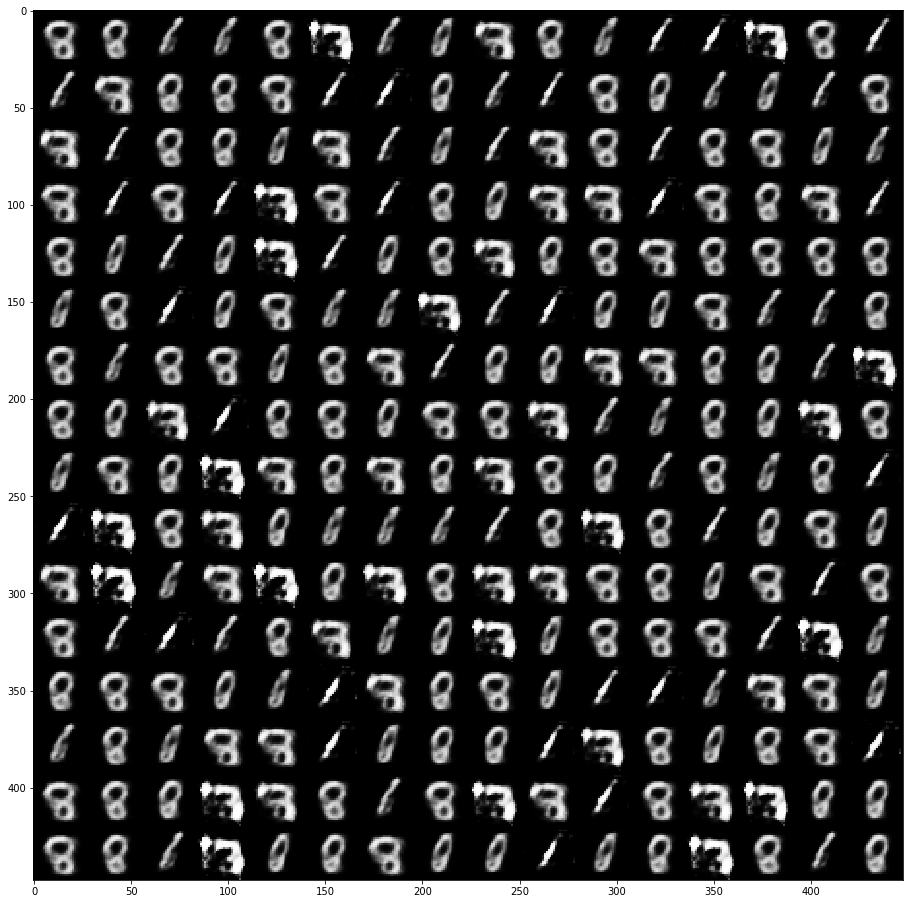

In [33]:
# latent是256个服从标准分布的Z，其中各分量都相同
ep = tf.keras.backend.random_normal([256, 1], dtype=tf.float32, mean=0., stddev=1.0)
latent = tf.repeat(ep, tf.fill([1], 10), axis=1)

draw_all_in_a_batch(latent)

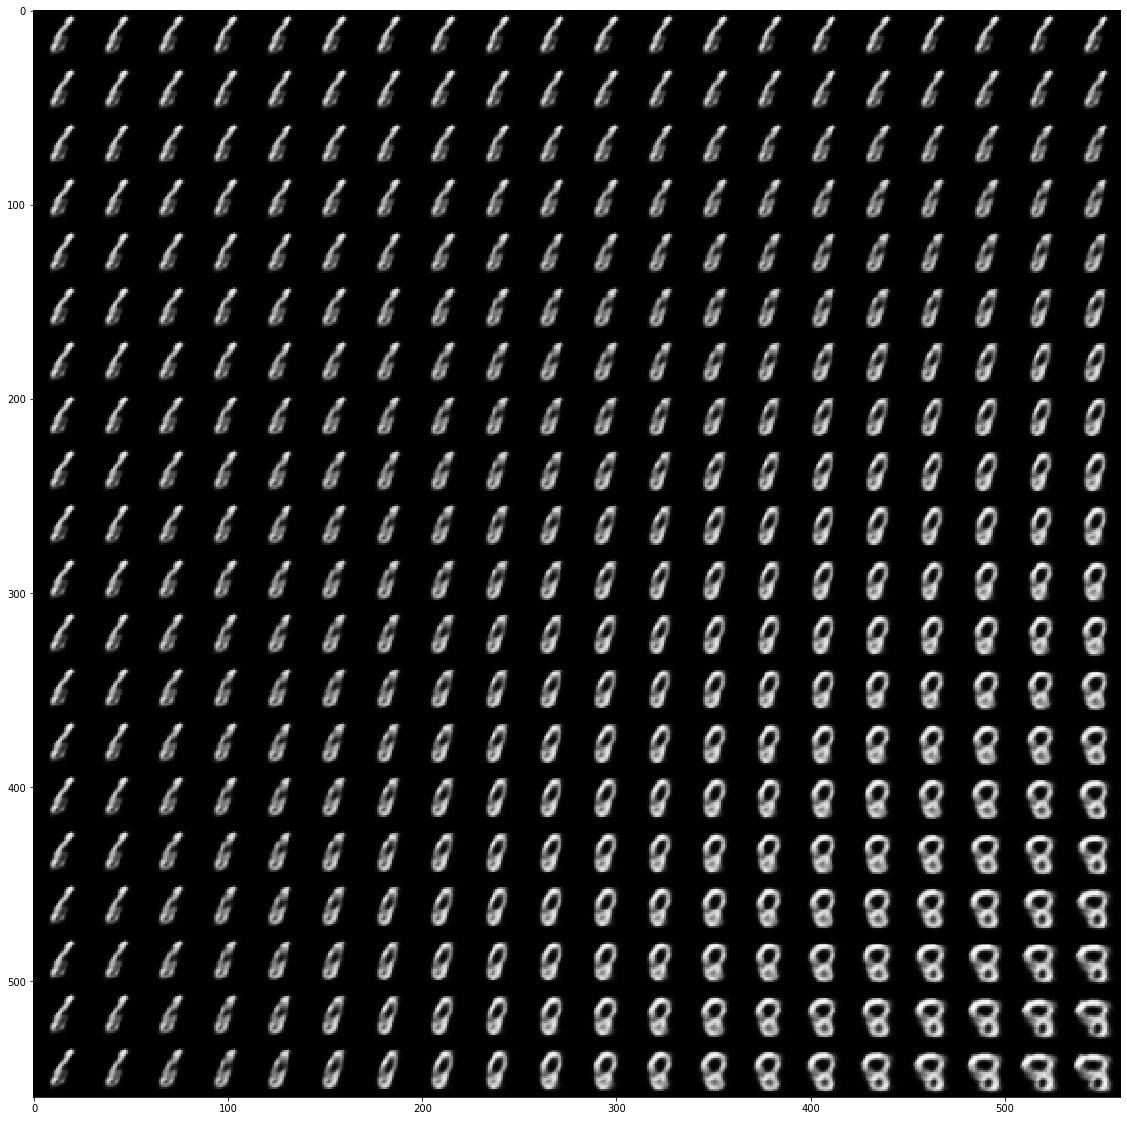

In [34]:
n = 20
canvas_recon = np.empty((28 * n, 28 * n))
# 受限于构造矩阵的能力，目前只能生成256个一样的latent，构成(256, latent)作为输入，然后选择(256, 784)输出的第一个作为本次输出的结果
# 要运行n*n次才行。目标是直接生成256个不一样的，递进的latent
x_axis = np.linspace(-1, 1, n*n)

for i in range(n):
    for j in range(n):
        latent = np.array([np.array([x_axis[i*j]]).repeat(num_latent)] * batch_size)
        new_images = vae.decode(latent)
        img = new_images[0].numpy().reshape([28, 28])
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
        
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()

todo，关于latent多少才够？我猜测，如果有10个类比的数字，那么latent大小设置成10会比较好

如果要生成这种渐变的图像，那么可以只变化2个维度，其他的都固定，这两个维度可以参考上面的做法，其变化和坐标相关，就可以实现渐变